# *Cross validation* I: Treinamento, Validação e Teste

### Índice <a name="topo"></a>
- 1. [Introdução](#1)
- 2. [Carregando a base](#2)
- 3. [Base de Treinamento, Validação e Teste](#3)
- 4. [Cálculo dos CCP-alphas](#4)
- 5. [Obtendo a melhor árvore](#5)
- 6. [Avaliando a melhor árvore](#6)
- 7. [Gancho para a próxima aula](#7)


### 1. Introdução <a name="1"></a>
[Voltar para o índice](#topo)

O gancho da aula passada:

- Será que "demos sorte" de a base de testes ter esse desempenho?  
- Com outra base teriamos o mesmo desempenho?  
- Como podemos obter uma métrica mais "confiável" do desempenho desse algoritmo?

Na aula passada, como a base de testes foi utilizada para 'tunar' o modelo, é razoável imaginarmos que ao aplicar o modelo a uma base mais ampla, não vamos obter exatamente esta acurácia.

Vamos fazer uma primeira tentativa de resolver este problema separando uma base de testes *holdout*, que não será utilizada nem no desenvolvimento do modelo, nem na escolha dos hiperparâmetros, e no final, vamos avaliar a qualidade do modelo nesta base.

### 2. Carregando a base<a name="2"></a>
[Voltar para o índice](#topo)

Nesta aula vamos carregar a base já tratada na aula passada, com os valores faltantes da variável ```sex``` preenchidos.

In [129]:
import pandas            as pd 
import numpy             as np 
import seaborn           as sns
import matplotlib.pyplot as plt
from sklearn.tree            import DecisionTreeClassifier
from sklearn.metrics         import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [154]:
with open('features.txt', 'r') as f:
    features = pd.Series([line.strip() for line in f])

feature_names = features.str.extract(r'\d+\s+(.*)')[0].tolist()

with open('test/subject_test.txt', 'r') as f:
    subject_test = pd.Series([int(line.strip()) for line in f]) 

with open('test/y_test.txt', 'r') as f:
    y_test = pd.Series([int(line.strip()) for line in f]) 

with open('train/y_train.txt', 'r') as f:
    y_train = pd.Series([int(line.strip()) for line in f]) 

with open('train/subject_train.txt', 'r') as f:
    subject_train = pd.Series([int(line.strip()) for line in f]) 


selected_columns = ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z']


X_train = pd.read_csv('train/X_train.txt', delim_whitespace=True, header=None)
X_train.columns = feature_names
X_train.insert(0, 'subject', subject_train)
X_train_selected = X_train[selected_columns]


X_test = pd.read_csv('test/X_test.txt', delim_whitespace=True, header=None)
X_test.columns = feature_names
X_test.insert(0,'subject', subject_test)
X_test_selected = X_test[selected_columns]


X_test_selected.index = pd.MultiIndex.from_arrays(
    [X_test.index, X_test['subject']],
    names=['order', 'subject']
)

X_train_selected.index = pd.MultiIndex.from_arrays(
    [X_train.index, X_train['subject']],
    names=['order', 'subject']
)

X_, X_tester, y_, y_tester = train_test_split(X_test_selected, 
                                            y_test, 
                                            test_size=.2, 
                                            random_state=2360873)

X_trainer, X_valid, y_trainer, y_valid = train_test_split(X_, 
                                                      y_, 
                                                      test_size=.25, 
                                                      random_state=2360873)

caminho = DecisionTreeClassifier(random_state=2360873).cost_complexity_pruning_path(X_trainer, y_trainer)


In [155]:
ccp_alphas, impurities = caminho.ccp_alphas, caminho.impurities
ccp_alphas

array([0.        , 0.00037729, 0.00037729, 0.00037729, 0.00042445,
       0.00042445, 0.00042445, 0.00042445, 0.00042445, 0.00042445,
       0.00042445, 0.00042445, 0.00042445, 0.00042445, 0.00042445,
       0.00042445, 0.00044466, 0.00045274, 0.00045274, 0.00045274,
       0.00045274, 0.00045274, 0.00045274, 0.00045274, 0.00045274,
       0.00045274, 0.00045274, 0.00045274, 0.00045274, 0.00047161,
       0.00047161, 0.00047161, 0.00047161, 0.00047161, 0.00047161,
       0.00047161, 0.00047161, 0.00047161, 0.00048508, 0.00048508,
       0.00048508, 0.00048508, 0.00048508, 0.00048508, 0.00048876,
       0.00049519, 0.00049519, 0.00049519, 0.00049519, 0.00050305,
       0.00050305, 0.00050934, 0.00050934, 0.00050934, 0.00050934,
       0.00051877, 0.00051877, 0.0005224 , 0.00052551, 0.00052551,
       0.0005282 , 0.00053264, 0.00053359, 0.00053763, 0.00054235,
       0.0005468 , 0.00056593, 0.00056593, 0.00056593, 0.00056593,
       0.00056593, 0.00056593, 0.00056593, 0.00056593, 0.00056

In [156]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=2360873, ccp_alpha=ccp_alpha).fit(X_trainer, y_trainer)
    clfs.append(clf)

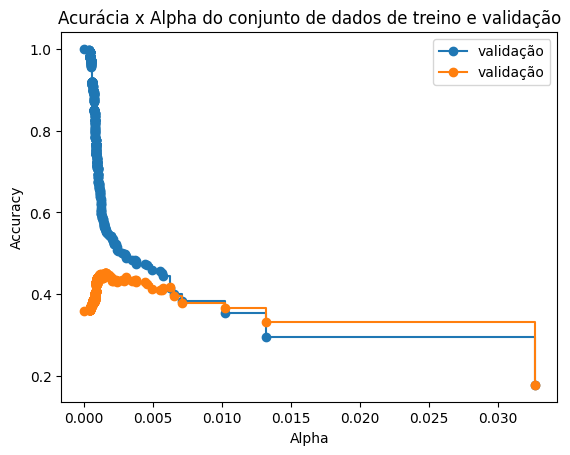

In [157]:
train_scores = [clf.score(X_trainer, y_trainer) for clf in clfs]
valid_scores = [clf.score(X_valid, y_valid) for clf in clfs]

fig, axs = plt.subplots()
axs.set_xlabel("Alpha")
axs.set_ylabel("Accuracy")
axs.set_title("Acurácia x Alpha do conjunto de dados de treino e validação")
axs.plot(ccp_alphas,train_scores,marker='o',label='validação',drawstyle='steps-post')
axs.plot(ccp_alphas,valid_scores,marker='o',label='validação',drawstyle='steps-post')
axs.legend()

In [158]:
ind_melhor_arvore = len(valid_scores) - valid_scores[::-1].index(max(valid_scores)) - 1
melhor_arvore = clfs[ind_melhor_arvore]

print(f'Acurácia da melhor árvore na base de validação: {valid_scores[ind_melhor_arvore]*100:.2f}')

melhor_arvore

Acurácia da melhor árvore na base de validação: 45.25


DecisionTreeClassifier(ccp_alpha=0.0015744489428699965, random_state=2360873)

Acurácia: 46.27


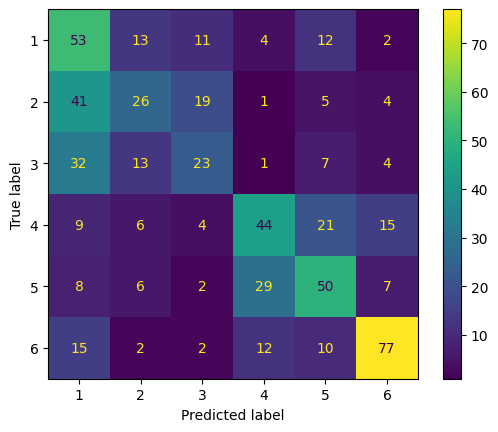

In [159]:
acuracia_teste = melhor_arvore.score(X_tester, y_tester)

print(f'Acurácia: {acuracia_teste*100:.2f}')
ConfusionMatrixDisplay.from_estimator(melhor_arvore, X_tester, y_tester)